In [4]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, exp, log, pi

### Dispertion analysis

In the simulation we set the initial STD of the gaussian profile. 

$$ \exp \left(- \frac{(x -x_i)^2 }{2\sigma ^2 } \right) $$

The analytical law for pure diffusion of an initial dirac function is

$$ c(x,t)=\frac{c_0}{\sqrt{4\pi D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

Thus

$$ \sigma ^2 = 2 D t_i$$

with $t_i$ the initial time corresponding to t=0 in the simulaiton.

$$t_i =  \frac{\sigma ^2}{2 D }  $$

We have then

$$ 1=c_0/\sqrt{(4 \pi D t_i)} $$

$$ c_0=\sqrt{2 \pi \sigma ^2 } $$

The solution over time is 


$$ c(x,t)=\frac{\sqrt{2 \pi \sigma ^2 } }{\sqrt{4\pi D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

$$ c(x,t)=\frac{\sigma  }{\sqrt{2 D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

The unknowm is $D$, the apparent diffusion coefficient.



## Method using the FWHM 

At any time we have the STD of the gaussian profile : 

$$ \sigma_n ^2 = 2 D t_n$$

Therefor the apparent diffusion coefficient can be estimated as the slope og the linear fit of the function $f(tn)=\sigma_n^2/2$.

Where $\sigma_n$ is estimated from the Full Width at Half the Maximum, 

$$\sigma_n = \frac{FWHM}{\sqrt{8\ln 2}}   $$

In [342]:
# compute FWHM using the roots of a fitted spline
from scipy.interpolate import UnivariateSpline

def FWHM(X,Y):
    spline = UnivariateSpline(X, Y-np.max(Y)/2, s=0)
    roots=spline.roots() # find the roots
    if len(roots)==1 :
        #print('Warning : there is only one root to the spline, we return 2*dist(max)')
        fwhm=2*abs(X[np.argmax(Y)]-roots[0])
    elif len(roots)==2 :
        fwhm=abs(roots[1]-roots[0])
    else :
        #print('Error : unexpected number of roots of the fitted spline')
        fwhm=np.nan
    
    return fwhm


In [390]:
from sklearn import linear_model

# With only one linear fit 
def estimate_diff_FWHM_fit(spanTime,spanFWHM) :
    spanSigma=spanFWHM/(2*sqrt(2*log(2)))
    
    X = np.array(spanTime).reshape((-1, 1))
    y = np.array(spanSigma**2)/2

    regressor = linear_model.LinearRegression()
    regressor.fit(X, y)
    a = regressor.coef_[0]
    b = regressor.intercept_
    plt.figure()
    plt.plot(spanTime,spanSigma**2/2,'*')
    plt.plot(spanTime,a*(spanTime-(-b/a)))
    plt.xlabel('time (s)')
    plt.ylabel(u'$\sigma^2/2$')
    plt.title('linear fit for the FWHM method')

    return regressor.coef_[0]

# with the slope, can vary with time
def estimate_diff_FWHM_slope(spanTime,spanFWHM) :
    spanSigma=spanFWHM/(2*sqrt(2*log(2)))
    y = np.array(spanSigma**2)/2

    slope=np.diff(y)/np.diff(spanTime)
    
    plt.plot(spanTime[0:-1],slope,'*')
    plt.xlabel('time (s)')
    plt.ylabel('$Deff$')
    plt.title('Slope of \sigma^2/2 vs t')
    
    return slope

## Method using gaussian fit

We look for the best fit of the form 


$$ c(x,t)=\frac{\sigma  }{\sqrt{2 D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

with $D$ being the only unknown

In [403]:
def gaussian (x,t,s,D,L,xi) :
    return s/sqrt(2*D*t)*np.exp(-(x-xi)**2/(4*D*t))

Text(0, 0.5, 'c')

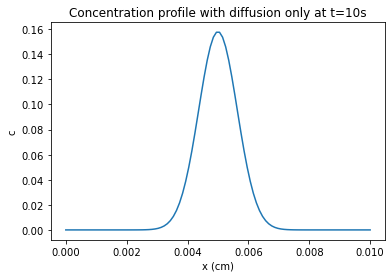

In [404]:
x=np.linspace(0,100e-4,100)
plt.plot(x,gaussian (np.array(x),10,1e-4,2e-8,100e-4,50e-4))
plt.title('Concentration profile with diffusion only at t=10s')
plt.xlabel('x (cm)')
plt.ylabel('c')

In [1041]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

def estimate_diff_fit(spanC,spanX,t,sigma,L,xi) :
    
    
    def fitfunction(x,D) :
        tini=sigma**2/(2*D)
        return  gaussian (spanX,t+tini,sigma,D,L,xi)
    
    popt, pcov = curve_fit(fitfunction, spanX,spanC,bounds=[1e-9,1e-4])
    
    fit = fitfunction(spanX,*popt)
    
    err=mean_squared_error(spanC, fit) 
        
    return popt[0], err

In [409]:
L=100e-4
Dtest=5.489e-8
xtest=np.linspace(0,L,100)
ttest=10
sigma=1e-4
# create a profile (that would normally come from the simulation)
profile_test=gaussian(xtest,ttest+sigma**2/(2*Dtest),sigma,Dtest,L,L)
#estimate the D coeff with fit
Dest, err = estimate_diff_fit(profile_test,xtest,ttest,sigma,L,L)

print('Estimation of D from fit : %.2e'%Dest)
print('Actual value of D : %.2e'%Dtest)
print('Error (pc): %.2e'%((Dest-Dtest)/Dtest*100))

Estimation of D from fit : 5.49e-08
Actual value of D : 5.49e-08
Error (pc): 2.23e-05


# Parameters

In [14]:
D=2e-8
mu=7e-3
rho=1

# Analysis of diffusion only

In [15]:
rep='/home/alexandra/Documents/Python/sleep/sleep/fbb_DD/output/diffusion-D0 /profiles/'
file='concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')

x=Data[0,1:]
t=Data[1:,0]

concentration=Data[1:,1:]

In [16]:
iperiodic=list(np.arange(0,len(t),1))
iperiodic

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

(0.0035, 0.0065)

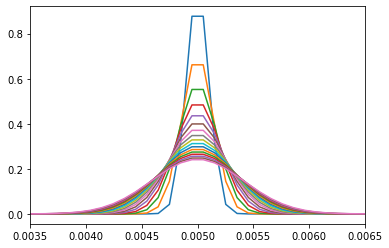

In [17]:
span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
    plt.plot(x,c)
    
span_FWHM=np.array(span_FWHM) 
plt.xlim([35e-4,65e-4])

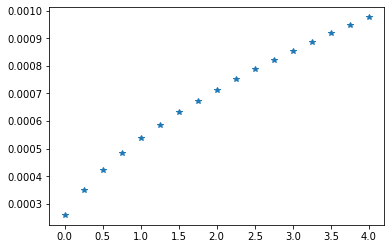

In [18]:
plt.plot(t[iperiodic],span_FWHM[iperiodic],'*')

### Estimation of D from FWHM

Text(0.5, 1.0, 'linear fit for the FWHM method')

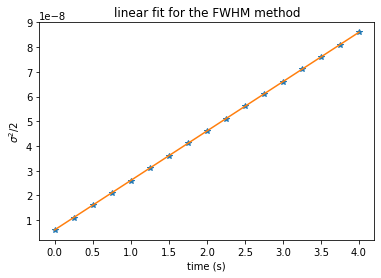

In [22]:
Dest0=estimate_diff_FWHM(t[iperiodic],span_FWHM[iperiodic])
plt.xlabel('time (s)')
plt.ylabel(u'$\sigma^2/2$')
plt.title('linear fit for the FWHM method')

In [23]:
print('Estimation of D from FWHM : %.2e'%Dest0)
print('Error (pc): %.2e'%(abs(Dest0-D)/D*100))

Estimation of D from FWHM : 2.00e-08
Error (pc): 2.61e-02


We recover the diffusion coefficient from the simulation.

### Estimation of D from fit

Text(0.5, 1.0, 'Estimate of D with fit method')

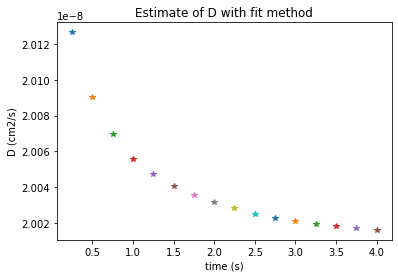

In [24]:
# we take the time at last period

spanDest=[]
for itime in iperiodic[1:] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, err = estimate_diff_fit(concentration[itime],x,t[itime],1e-4,100e-4)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    
    spanDest.append(Dest)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

In [25]:
print('Estimation of D from FWHM : %.2e'%spanDest[-1])
print('Error (pc): %.2e'%(abs(spanDest[-1]-D)/D*100))

Estimation of D from FWHM : 2.00e-08
Error (pc): 8.02e-02


Both methods give good results. The fit method needs longer time as it is converging.

(0.0035, 0.0065)

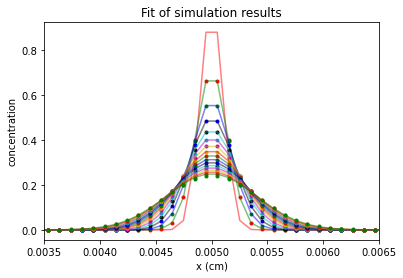

In [26]:
iest=0
color='rgbkcmyrgbkcmyrgbkcmy'
for i in iperiodic[1:] :
    plt.plot(x,concentration[i],'.',color=color[iest])
    plt.plot(x,gaussian(np.array(x),t[i],1e-4,spanDest[iest],100e-4),color=color[iest],alpha=0.5)
    iest+=1
plt.xlabel('x (cm)')
plt.ylabel('concentration')
plt.title('Fit of simulation results')
plt.xlim([35e-4,65e-4])

# Analysis of pulsating simulation

In [1250]:
Database=[]
datalabel=['job', 'Rv0', 'Rpvs', 'L', 'DX', 'dt', 'rho', 'mu', 'D', 'sigma', 'xi', 'f', 'umax','pmax', 'Pe', 'Re', 'Wo', 'Fo' , 'A', 'beta', 'dPdx', 'T','nPeriod' , 'tend', 'FWHMend','DestFWHM', 'Destfit', 'RFWHM', 'Rfit', 'amp']

### Load data

#### Simulation results

In [1303]:
job='10pc-02Hz-D0-xi100-sigma1'
rep='/home/alexandra/Documents/Python/sleep/sleep/output/'+job+'/'
file='profiles/concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')

x=Data[0,1:]
t=Data[1:,0]

concentration=Data[1:,1:]

pressure=np.loadtxt(rep+'profiles/pressure.txt',delimiter=',')[1:,1:]

velocity=np.loadtxt(rep+'profiles/velocity.txt',delimiter=',')[1:,1:]

#### Simulation parameters

In [1304]:
import re
scinot = re.compile('[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)')

# Should get D, L, rho, nu, f, amp, Rpvs, Rv0,sigma and x0 from the log file
file='PVS_info.log'


with open(rep+file) as fl:
    line = fl.readline()
    while line:
        line = fl.readline()
        if line[0:6] == 'Vessel' :
            Rv0=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'PVS ra' :
            Rpvs=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'PVS le' :
            L=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'densit' :
            rho=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'dynami' :
            mu=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'Free d' :
            D=float(re.findall(scinot, line)[0]) 
        elif line[0:6] == 'STD of' :
            sigma=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'Initia' :
            xi=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'fi (Hz':
            f=float(re.findall(scinot, line)[0]) # Check if it works for several frequencies
        elif line[0:6] == 'ai (di':
            amp=float(re.findall(scinot, line)[0])*100 # Check if it works for several frequencies
            
print('Rv : %.2f um'%(Rv0*1e4))
print('Rpvs : %.2f um'%(Rpvs*1e4))
print('Length : %.2f um'%(L*1e4))

print('\nDensity : %.2e g/cm3'%rho)
print('Viscosity : %.2e dyn s /cm2'%mu)
nu=mu/rho

print('\nDiffusion coefficient: %.2e cm2/s'%(D))      
print('STD gausian : %.2e cm'%(sigma))
print('center gaussian: %.2e um'%(xi*1e4))

print('\nfrequency : %.2e Hz'%f)
print('\namplitude : %.2e pc'%amp)

Rv : 8.00 um
Rpvs : 10.00 um
Length : 200.00 um

Density : 1.00e+00 g/cm3
Viscosity : 7.00e-03 dyn s /cm2

Diffusion coefficient: 2.00e-08 cm2/s
STD gausian : 1.00e-04 cm
center gaussian: 1.00e+02 um

frequency : 2.00e-01 Hz

amplitude : 1.00e+01 pc


### Compute dimensionless numbers

In [1305]:
umax=np.max(abs(velocity))
pmax=np.max(abs(pressure))


w=2*pi*f
h=Rpvs-Rv0

Pe=h*umax/D
Re=rho*umax*h/mu
Wo=h*sqrt(w/mu)
Fo=D*t[-1]/xi**2

print('Umax : %.0f um/s'%(umax*1e4))
print('Pmax : %.0f pa \n'%(pmax/10))

print('max Reynolds number : %.0e'%Re)
print('max Peclet number : %.0e'%Pe)
print('Womersley number : %.0e'%Wo)
print('Fourier number : %.0e'%Fo)

dPdx=pmax/L
beta=D/mu
A=pi*(Rpvs**2-Rv0**2)



Umax : 98 um/s
Pmax : 38 pa 

max Reynolds number : 3e-04
max Peclet number : 1e+02
Womersley number : 3e-03
Fourier number : 3e-03


In [1306]:
# We want to look to the results when v=0
# We add time shift of 1/4f
dt=t[1]-t[0]
if f:
    T=1/f
    ishift=int(T/dt*1/2)
else :
    T=t[-1]/10
    ishift=0

iperiodic=list(np.arange(ishift,len(t),int(T/dt)))

print('final time : %.2e s'%t[-1])
print('time step : %.2e s'%dt)
print('period : %.2e s'%T)
nPeriod=len(iperiodic)
print('number of period analysed: %i'%nPeriod)

final time : 1.50e+01 s
time step : 2.50e-01 s
period : 5.00e+00 s
number of period analysed: 3


In [1307]:
span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
    #plt.plot(x,c)
    
span_FWHM=np.array(span_FWHM) 
#plt.xlim([35e-4,65e-4])

 

In [1308]:
DX=(x[1]-x[0])*1e4
print('spatial resotion : %.2e um'%(DX))



spatial resotion : 2.02e+00 um


Text(0.5, 1.0, 'computed FWHM')

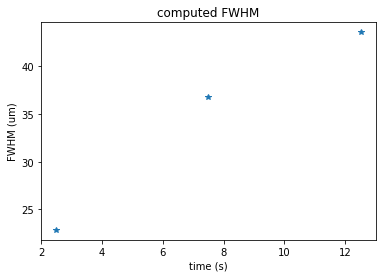

In [1309]:
plt.plot(t[iperiodic],span_FWHM[iperiodic]*1e4,'*')
plt.xlabel('time (s)')
plt.ylabel('FWHM (um)')
plt.title('computed FWHM')



### Estimation of D from FWHM

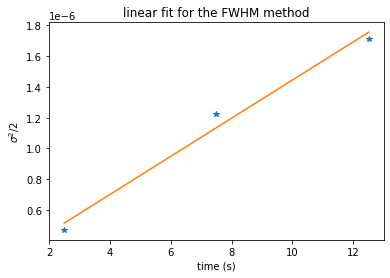

In [1310]:
Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])



In [1311]:
DestFWHM=Dest
print('Estimation of D from FWHM : %.2e'%DestFWHM)

Estimation of D from FWHM : 1.24e-07


When the apparent Diffusion coefficient is smaller with oscillation than diffusion alone at small time. What is going on? 

### Estimation of D from fit

Text(0.5, 1.0, 'Estimate of D with fit method')

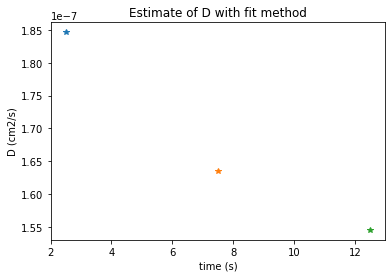

In [1312]:
# we take the time at last period

spanDest=[]
for itime in iperiodic : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, err = estimate_diff_fit(concentration[itime],x,t[itime],sigma,L,xi)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    spanDest.append(Dest)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

In [1313]:
Destfit=spanDest[-1]
print('Estimation of D from fit : %.2e'%Destfit)

Estimation of D from fit : 1.55e-07


Text(0.5, 1.0, 'Fit of simulation results')

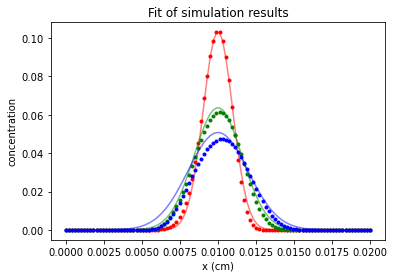

In [1314]:
color='rgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmy'
icol=0
for i in range(0,len(spanDest)) :
    plt.plot(x,concentration[iperiodic[i]],'.',color=color[icol])
    plt.plot(x,gaussian(np.array(x),t[iperiodic[i]]+sigma**2/(2*spanDest[i]),sigma,spanDest[i],L,xi),color=color[icol],alpha=0.5)
    icol+=1
plt.xlabel('x (cm)')
plt.ylabel('concentration')
plt.title('Fit of simulation results')
#plt.xlim([L-50e-4,L])

### Update database

In [1315]:
Database.append([job, Rv0, Rpvs, L, DX, dt, rho, mu, D, sigma, xi, f, umax,pmax, Pe, Re, Wo, Fo , A, beta, dPdx, T,nPeriod , t[-1], span_FWHM[iperiodic[-1]],DestFWHM, Destfit,DestFWHM/D, Destfit/D, amp])

### Save database

In [1178]:
labelstring=''
for d in datalabel:
    labelstring+=d+', '
    
labelstring=labelstring[0:-1]

In [1316]:
f = open("data_dispersion_amp_withf02.csv", "w")
f.write(labelstring+'\n')
f.close()

In [1317]:
formatstring='%s'+' , %.6e'*29

In [1318]:
f = open("data_dispersion.csv", "a")
for d in Database :
    print(formatstring%tuple(d))
    f.write(formatstring%tuple(d)+'\n')
f.close()

1pc-02Hz-D0-xi100-sigma1 , 8.000000e-04 , 1.000000e-03 , 2.000000e-02 , 2.020202e+00 , 2.500000e-01 , 1.000000e+00 , 7.000000e-03 , 2.000000e-08 , 1.000000e-04 , 1.000000e-02 , 2.000000e-01 , 8.821285e-04 , 1.873379e+01 , 8.821285e+00 , 2.520367e-05 , 2.679698e-03 , 3.000000e-03 , 1.130973e-06 , 2.857143e-06 , 9.366895e+02 , 5.000000e+00 , 3.000000e+00 , 1.500000e+01 , 1.744246e-03 , 2.143063e-08 , 2.125393e-08 , 1.071531e+00 , 1.062696e+00 , 1.000000e+00
2pc-02Hz-D0-xi100-sigma1 , 8.000000e-04 , 1.000000e-03 , 2.000000e-02 , 2.020202e+00 , 2.500000e-01 , 1.000000e+00 , 7.000000e-03 , 2.000000e-08 , 1.000000e-04 , 1.000000e-02 , 2.000000e-01 , 1.764257e-03 , 3.870337e+01 , 1.764257e+01 , 5.040734e-05 , 2.679698e-03 , 3.000000e-03 , 1.130973e-06 , 2.857143e-06 , 1.935168e+03 , 5.000000e+00 , 3.000000e+00 , 1.500000e+01 , 1.899726e-03 , 2.572429e-08 , 2.535916e-08 , 1.286215e+00 , 1.267958e+00 , 2.000000e+00
4pc-02Hz-D0-xi100-sigma1 , 8.000000e-04 , 1.000000e-03 , 2.000000e-02 , 2.020202

### Plot results

In [1319]:
for i,label in enumerate(datalabel) :
    print('%i :'%i+label)

0 :job
1 :Rv0
2 :Rpvs
3 :L
4 :DX
5 :dt
6 :rho
7 :mu
8 :D
9 :sigma
10 :xi
11 :f
12 :umax
13 :pmax
14 :Pe
15 :Re
16 :Wo
17 :Fo
18 :A
19 :beta
20 :dPdx
21 :T
22 :nPeriod
23 :tend
24 :FWHMend
25 :DestFWHM
26 :Destfit
27 :RFWHM
28 :Rfit
29 :amp


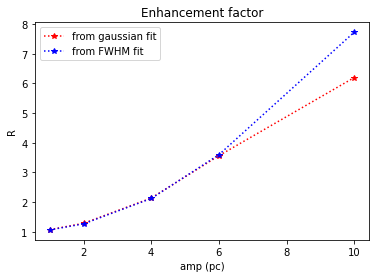

In [1320]:
ix=29
iy=25

xplot=[d[ix] for d in Database]
yplot=[d[iy]/2e-8 for d in Database]

plt.plot(xplot,yplot,'r*:',label='from gaussian fit')

iy=26
xplot=[d[ix] for d in Database]
yplot=[d[iy]/2e-8 for d in Database]
plt.plot(xplot,yplot,'b*:',label='from FWHM fit')

plt.title('Enhancement factor')
plt.ylabel('R'+'')
plt.xlabel(datalabel[ix]+' (pc)')
plt.legend()

Text(0.5, 0, 'amp (pc)')

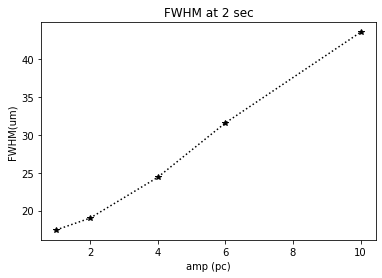

In [1321]:
ix=29
iy=24

xplot=[d[ix] for d in Database]
yplot=[d[iy]*1e4 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('FWHM at 2 sec')
plt.ylabel('FWHM'+'(um)')
plt.xlabel(datalabel[ix]+' (pc)')


Text(0.5, 0, 'amp (pc)')

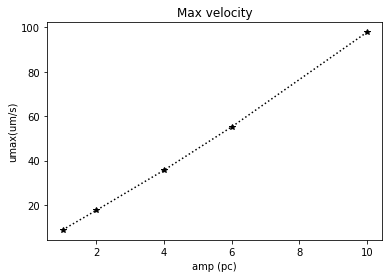

In [1322]:
ix=29
iy=12

xplot=[d[ix] for d in Database]
yplot=[d[iy]*1e4 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max velocity')
plt.ylabel(datalabel[iy]+'(um/s)')
plt.xlabel(datalabel[ix]+' (pc)')

Text(0.5, 0, 'amp (pc)')

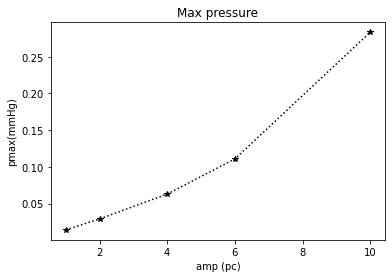

In [1323]:
ix=29
iy=13

xplot=[d[ix] for d in Database]
yplot=[d[iy]/1333 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max pressure')
plt.ylabel(datalabel[iy]+'(mmHg)')
plt.xlabel(datalabel[ix]+' (pc)')

Text(0.5, 0, 'amp (pc)')

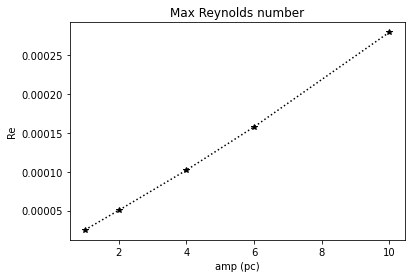

In [1324]:
ix=29
iy=15

xplot=[d[ix] for d in Database]
yplot=[d[iy] for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max Reynolds number')
plt.ylabel(datalabel[iy])
plt.xlabel(datalabel[ix]+' (pc)')

Text(0.5, 0, 'amp pc')

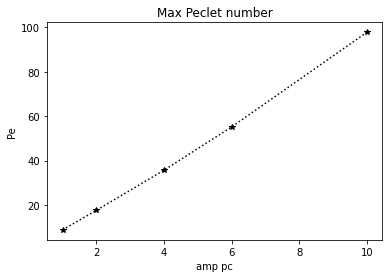

In [1325]:
ix=29
iy=14

xplot=[d[ix] for d in Database]
yplot=[d[iy] for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max Peclet number')
plt.ylabel(datalabel[iy])
plt.xlabel(datalabel[ix]+' pc')

# Analysis of NREM waves

In [250]:
Rv0=8e-4
Rpvs=10e-4
f=1 #Hz
amp=0.1

In [257]:
rep='/home/alexandra/Documents/Python/sleep/sleep/fbb_DD/output/10pc-1Hz-cyl-D0 /profiles/'
file='concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')

x=Data[0,1:]
t=Data[1:,0]

concentration=Data[1:,1:]

pressure=np.loadtxt(rep+'pressure.txt',delimiter=',')[1:,1:]

velocity=np.loadtxt(rep+'velocity.txt',delimiter=',')[1:,1:]

In [258]:
umax=np.max(abs(velocity))
pmax=np.max(abs(pressure))
w=2*pi*f
h=Rpvs-Rv0

Pe=h*umax/D
Re=rho*umax*h/mu
Wo=h*sqrt(w/nu)

print('Umax : %.0f um/s'%(umax*1e4))
print('Pmax : %.0f pa \n'%(pmax/10))

print('Reynolds number : %.0e'%Re)
print('Peclet number : %.0e'%Pe)
print('Womersley number : %.0e'%Wo)

dPdx=pmax/(L/2)
beta=D/mu
A=pi*(Rpvs**2-Rv0**2)

Umax : 167 um/s
Pmax : 6 pa 

Reynolds number : 5e-04
Peclet number : 2e+02
Womersley number : 6e-03


In [259]:
dt=t[2]-t[1]
T=1/f
iperiodic=list(np.arange(0,len(t),int(T/dt)))

In [260]:
span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
span_FWHM=np.array(span_FWHM) 

Text(0.5, 1.0, 'computed FWHM')

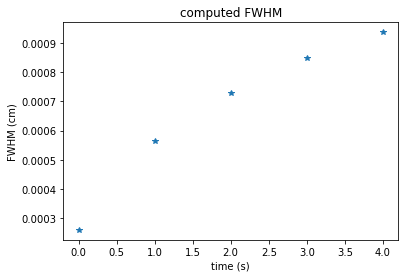

In [261]:
plt.plot(t[iperiodic],span_FWHM[iperiodic],'*')
plt.xlabel('time (s)')
plt.ylabel('FWHM (cm)')
plt.title('computed FWHM')

### Estimation of D from FWHM

Text(0.5, 1.0, 'linear fit for the FWHM method')

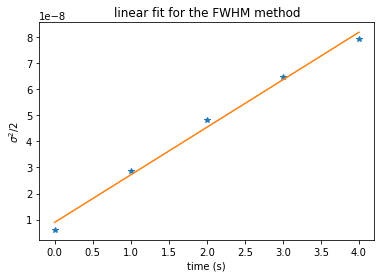

In [262]:
Dest0=estimate_diff(t[iperiodic],span_FWHM[iperiodic])
plt.xlabel('time (s)')
plt.ylabel(u'$\sigma^2/2$')
plt.title('linear fit for the FWHM method')

In [263]:
print('Estimation of D from FWHM : %.2e'%Dest0)

Estimation of D from FWHM : 1.82e-08


The apparent Diffusion coefficient is smaller with oscillation than diffusion alone. 
This must be due to the slice location. I should use the integrate over the cros section.

### Estimation of D from fit

Text(0.5, 1.0, 'Estimate of D with fit method')

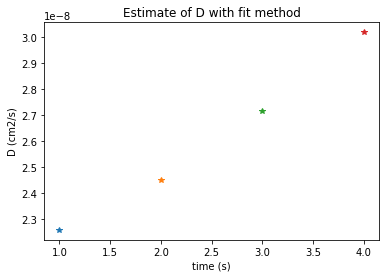

In [264]:
# we take the time at last period

spanDest=[]
for itime in iperiodic[1:] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, err = estimate_diff_fit(concentration[itime],x,t[itime],1e-4,100e-4)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    
    spanDest.append(Dest)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

In [265]:
print('Estimation of D from FWHM : %.2e'%spanDest[-1])

Estimation of D from FWHM : 3.02e-08
